In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

In [4]:
df = pd.read_csv("/home/andres/data/hbmep-processed/L_CIRC/data.csv")
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
combination = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/combine.pkl", "rb"))

In [6]:
set(k[1] for k in combination.keys())

{'-C6LC',
 '-C6LE',
 '-C6LN',
 '-C6LNE',
 '-C6LNW',
 '-C6LS',
 '-C6LSE',
 '-C6LSW',
 '-C6LW',
 'C6LE-C6LC',
 'C6LE-C6LW',
 'C6LN-C6LC',
 'C6LNE-C6LC',
 'C6LNE-C6LSW',
 'C6LNW-C6LC',
 'C6LS-C6LC',
 'C6LS-C6LN',
 'C6LSE-C6LC',
 'C6LSE-C6LNW',
 'C6LSW-C6LC',
 'C6LW-C6LC'}

In [7]:
subjects = df['participant'].unique()
combos = ['Vertex', 'Radius', 'Diameter']
electrodes = ['C6LC', 'C6LE', 'C6LN', 'C6LNE', 'C6LNW', 'C6LS', 'C6LSE', 'C6LSW', 'C6LW']
muscles = model.response

In [8]:
temp = ['C6LE-C6LW','C6LNE-C6LSW','C6LS-C6LN','C6LSE-C6LNW']
ord = []
arr = []
mask = []
for sub in subjects:
    for combo in combos:
        for elec in electrodes:
            for m in muscles:
                if combo == 'Vertex':
                    position = '-'+elec
                if combo == 'Radius':
                    position = elec + '-' + 'C6LC'
                if combo == 'Diameter':
                    for e in electrodes:
                        if elec != e:
                            temppos = elec + '-' + e
                            if temppos in temp:
                                position = temppos
                key = (sub, position, m)
                
                if key in combination.keys():
                    tcomb = combination[key]['a']
                    tcomb = tcomb.reshape(-1, 1)
                    arr.append(tcomb)
                    mask.append(np.full((4000,1), False))
                else:
                    arr.append(np.zeros(4000).reshape(-1, 1))
                    mask.append(np.full((4000, 1), True))
                    
arr = np.array(arr)
arr = arr.reshape(len(subjects), len(combos),len(electrodes), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(combos),len(electrodes),len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]
                

In [9]:
set(ord)

set()

In [10]:
arr.shape #subjects, combos, electrodes, muscles

(8, 3, 9, 6, 4000)

In [11]:
def get_pvalues(a):
    pvalues = []
    mask = []
    data = []
    means =[]
    labels = []

    orientation_ind = a
    if orientation_ind == 0:
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            label = f"{l_electrode}"
            labels.append(label)
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                
                mask.append(False)

                l_samples = arr[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = arr[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(9, 9)

        mask = np.array(mask)
        mask = mask.reshape(9, 9)

        data = np.array(data)
        data = data.reshape(9, 9)

        means = np.array(means)
        means = means.reshape(9, 9)

                        
    if orientation_ind == 1: #radius 
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            if l_electrode == 'C6LC':
                continue
            label = f"{l_electrode}-C6LC"
            labels.append(label)
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                if r_electrode == 'C6LC':
                    continue
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                mask.append(False)

                l_samples = arr[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = arr[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(8, 8)

        mask = np.array(mask)
        mask = mask.reshape(8, 8)

        data = np.array(data)
        data = data.reshape(8, 8)

        means = np.array(means)
        means = means.reshape(8, 8)

        
    if orientation_ind == 2: #diameter 
        labels = ['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                if (l_electrode not in (l.split("-")[0] for l in labels)) | (r_electrode not in (l.split("-")[0] for l in labels)):
                    continue
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    means.append(0)
                    data.append(1)
                    continue
                mask.append(False)

                l_samples = arr[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = arr[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(4, 4)

        mask = np.array(mask)
        mask = mask.reshape(4, 4)

        data = np.array(data)
        data = data.reshape(4, 4)

        means = np.array(means)
        means = means.reshape(4, 4)
    
    if (orientation_ind == 0) | (orientation_ind == 1): #vertex
        mask2= mask
        mask2 = np.tril(np.ones_like(mask2), k=-1)
        mask2 = mask2

        plt.figure(figsize=(15, 5))
        values = means
        handles = []
        cmap = 'coolwarm'
        ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
        plt.xticks(rotation=45);
        hatch_mask = pvalues > 0.05

        for i in range (pvalues.shape[0]):
            for j in range(pvalues.shape[1]):
                if hatch_mask[i, j]:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='', label="Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='////', label="Not Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                            hatch='', label="Row Element Lower Threshold"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                            hatch='', label="Row Element Higher Threshold"))
        ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
                handlelength=2, handleheight=2, frameon=False)
        ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

        ax.yaxis.tick_right()
        plt.show()
    
    if orientation_ind == 2: 
        mask2= mask
        mask2 = np.tril(np.ones_like(mask2))
        mask2 = mask2

        plt.figure(figsize=(15, 5))
        values = means
        handles = []
        cmap = 'coolwarm'
        ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
        plt.xticks(rotation=45);
        hatch_mask = pvalues > 0.05

        for i in range (pvalues.shape[0]):
            for j in range(pvalues.shape[1]):
                if hatch_mask[i, j]:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='', label="Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='////', label="Not Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                            hatch='', label="Row Element Lower Threshold"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                            hatch='', label="Row Element Higher Threshold"))
        ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
                handlelength=2, handleheight=2, frameon=False)
        ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

        ax.yaxis.tick_right()
        plt.show()

In [13]:
labels = ['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']
s = list((l[0] for l in labels))
s

['C', 'C', 'C', 'C']

In [14]:
pvalues = []
mask = []
data = []
means =[]
labels = []

orientation_ind = 1

for l_electrode_ind, l_electrode in enumerate(electrodes):
    label = f"{l_electrode}"
    labels.append(label)
    for r_electrode_ind, r_electrode in enumerate(electrodes):
        if (l_electrode == r_electrode):
            pvalues.append(1)
            mask.append(True)
            data.append(label)
            means.append(0)
            continue
        
        mask.append(False)

        l_samples = arr[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
        r_samples = arr[:, orientation_ind,r_electrode_ind,...] 
        
        t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

        ttest = stats.ttest_1samp(
            t, popmean=0, alternative="two-sided", axis=(0, 1)
        )

        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)

        t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
        data.append(
            f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
        )
        means.append(t.mean())

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(9, 9)

mask = np.array(mask)
mask = mask.reshape(9, 9)

data = np.array(data)
data = data.reshape(9, 9)

means = np.array(means)
means = means.reshape(9, 9)

pvalues.shape

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1189404/3612135074.py:36: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1189404/3612135074.py:49: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


(9, 9)

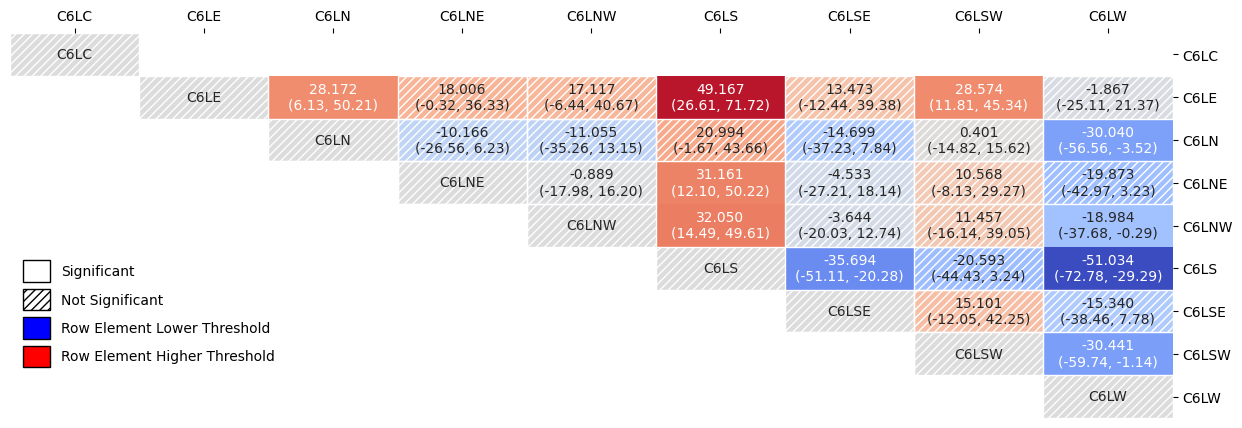

In [15]:
mask2= mask
mask2 = np.tril(np.ones_like(mask2), k=-1)
mask2 = mask2

plt.figure(figsize=(15, 5))
values = means
handles = []
cmap = 'coolwarm'
ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
plt.xticks(rotation=45);
hatch_mask = pvalues > 0.05

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()